# Homework III: Deep Reinforcement Learning

## Sabrina Giorgetti - 2013375 -  sabrina.giorgetti@studenti.unipd.it

##  Index

1. [Introduction](#Introduction)<br>
    1.1 [Import](#Import)<br>
    1.2 [Enable gym environment rendering in Colab](#Enable-gym-environment-rendering-in-Colab)<br>
2. [Reinforcement learning](#Reinforcement-learning)<br>
    2.1 [Experience replay (Replay Memory)](#Experience-replay-(Replay-Memory))<br>
    2.2 [Policy network](#Policy-network)<br>
    2.3 [Exploration Policy](#Exploration-Policy)<br>
3. [Gym Environment CartPole-v1](#Gym-Environment-CartPole-v1)<br>
    3.1 [Network update](#Network-update)<br>
    3.2 [Run basic CartPole](#Run-basic-CartPole)<br>
    3.3 [Final test basic CartPole](#Final-test-basic-CartPole) 
4. [Optimization with hyperameters tuning](#Optimization-with-hyperameter-tuning)<br>
    4.1 [Optuna-study](#Optuna-study)<br>
5. [Optimized CartPole-v1](#Best-Autoencoder)<br>
    4.2 [Results and comparison](#Results-and-comparison)<br>
5. [Gym Environment MountainCar-v0](#Gym-Environment-MountainCar-v0)<br>
    5.1 [Make MountainCar-v0 environment](#Make-MountainCar-v0-environment)<br>
    5.2 [Reinforced learning functions definition](#Reinforced-learning-functions-definition)<br>
    5.3 [Run](#Run)<br>
    5.4 [Final test](#Final-test)<br>


# Introduction

The goal is to train a Deep Q Learning (DQN) agent on the CartPole-v0 task from the OpenAI Gym. Gym has a diverse collection of reference environments and through its interface it is capable of representing general reinforcement learning problems. The task for the second part is instead the MountainCar-v0, always from the OpenAI Gym.

The implementation is carried out in a Python environment with a PyTorch framework and Optuna is used as an automatic tuning tool. The notebook has been run on Google Colab to facilitate the rendering of the video of the learnings problem. The videos are uploaded along with the notebook but all  the code and related files can also be found at this link: [GitHub Repo](https://github.com/giorgettisabrina/NNDL/tree/main/homework3). To render the videos directly in GitHub look at the gif folder.

Reinforcement learning (RL) is a machine learning technique that focuses on training an algorithm following a punishment-rewards approach.
The main player is the *agent* that interacts with an environment, its learning steps can be described as follows:

- The agent, in a *current state* at time t $s_{t}$ with a reward value $r_{t}$  interacts with the environment and receives a new observation $o_t$ 
- The agent then chooses an *action* $a_i$ from the set of actions available $ A=\{a_1,..,a_n\} $ with a *policy* strategy
- The agent moves to the *next stat*e $s_{t+1}$ in the environment, that is associated with a certain *reward*$r_{t+1}$ and updates its policy

The process is repeated iteratively with goal of the agent to maximize the accumulated rewards, and in the end to maximixe what is called the total return $G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$ with $k=,t+1,t+2... $ and $\gamma$ ($0 < \gamma \leq 1$) that specify how much we should care about future rewards.  

In the Deep Q-learning algorithms, the agent learns to associate a value, called Q-value, to each state-action pair $Q(s,a) = E[G_t|s,a]$. Based the policy adopted $\phi(s)$, which is a behaviour function selecting actions given a state, the actions tries to improve the Q-value over time in order to reach the optimal one: 


$$Q^{*}(s,a) = E[r+ \gamma max_{a'}Q^{*}(s',a') | s',a']$$

The optimal value function can be however be optimized by a deep neural network DQN and the model is trained to minimize the following loss function:


$$L = E[(r + \gamma max_{a'}Q^T(s',a',\theta)- Q(s,a,\theta))]^2 $$

where the third term $Q$ is value of the prediction network trained at each step, while $Q^T$ is the value of the target network used for action selection and periodically updated. 


In the following sections of the notebook one can see how the different pieces have been implemented and more details are provided in the reletive parts following the structure and comments of the notebook provided during Lab07 and at base of this homework.

**Required tasks**

Grade: The maximum grade for this homework will be 8 points. Points will be assigned based on the correct implementation of the following items:
- 3 pt: use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).
- 5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms.

## Import 

In [1]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

## Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.co

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Reinforcement learning

## Experience replay (Replay Memory)

To make the convergence faster one can also implement an experience replay that stores the agent's experiences with a predefined capacity, in this way the agents learn when it has had multiple experiences, the elements are replaced only  when it reaches the maximum capacity. 

In [8]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions. The network is composed simply by fully-connected feed forward structure with three linear layers of 128 neurons each and with `state_space_dim` (state space dimension) as input and `action_space_dim` (action space dimension) as output, the activation function choosen is Tanh. 


In [9]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            # TODO
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [10]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper actio: the action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration). This type of behaviour is controlled by the exploration policy:
The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [11]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state) #outputs are the q-values

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [12]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.04179788  0.09827858]


### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [13]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [14]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.04179788  0.09827858]


# Gym Environment CartPole-v1

The CartPole-v0 environment consists in a pole attached to a cart, which moves along a frictionless to the left ot to the right. The goal is to balance the pole and keep it upright for as long as possible,  by applying forces (-1, +1) in the left and right direction on the cart. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more reaches an angle greater of $\pm 12 ^{\circ}$ with respect to the vertical, or if the cart position is greater the $\pm 2.4$ which means that the center of the cart reaches the edge of the display.

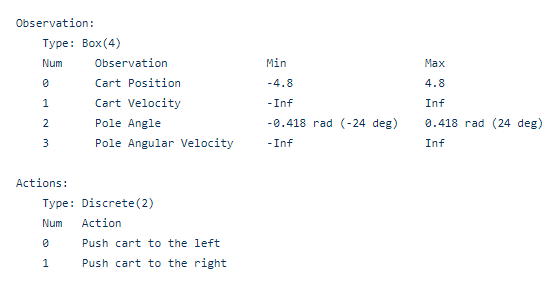

In [16]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [17]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      #Not really needed for now, move at random,do not update our policy, useful to keep track
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 24.0
EPISODE 2 - FINAL SCORE: 17.0
EPISODE 3 - FINAL SCORE: 14.0
EPISODE 4 - FINAL SCORE: 18.0
EPISODE 5 - FINAL SCORE: 12.0
EPISODE 6 - FINAL SCORE: 11.0
EPISODE 7 - FINAL SCORE: 13.0
EPISODE 8 - FINAL SCORE: 34.0
EPISODE 9 - FINAL SCORE: 15.0
EPISODE 10 - FINAL SCORE: 17.0


# Network update

### Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [19]:
### Initialize the replay memory

def initializer_rm(param_dict, state_space_dim=4, action_space_dim=2 ):
  replay_memory_capacity = param_dict['replay_memory_capacity']
  lr = param_dict['lr']

  replay_mem = ReplayMemory(replay_memory_capacity)    

  ### Initialize the policy network
  policy_net = DQN(state_space_dim, action_space_dim)

  ### Initialize the target network with the same weights of the policy network
  target_net = DQN(state_space_dim, action_space_dim)
  target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  ### Initialize the optimizer
  optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

  ### Initialize the loss function (Huber loss) 
  loss_fn = nn.SmoothL1Loss()

  return replay_mem, policy_net, target_net, optimizer, loss_fn

### Update function

In [20]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### Training loop (advanced)


In [21]:

def training(policy_net, target_net, replay_mem, exploration_profile, optimizer, loss_fn, param_dict):

  # Initialize the Gym environment
  env = gym.make('CartPole-v1') 
  env.seed(0) # Set a random seed for the environment (reproducible results)

  # This is for creating the output video in Colab, not required outside Colab
  env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

  score_list = []

  gamma = param_dict['gamma']
  batch_size = param_dict['batch_size']
  bad_state_penalty= param_dict['bad_state_penalty']
  target_net_update_steps = param_dict['target_net_update_steps']
  min_samples_for_training = param_dict['min_samples_for_training']

  for episode_num, tau in enumerate(tqdm(exploration_profile)):

      # Reset the environment and get the initial state
      state = env.reset()
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False

      # Go on until the pole falls off
      while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        env.render()

        # Set the current state for the next iteration
        state = next_state

      # Update the target network every target_net_update_steps episodes
      if episode_num % target_net_update_steps == 0:
          print('Updating target network...')
          target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      # Print the final score
      print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
      score_list.append(score)
  env.close()

  return score_list

## Run basic CartPole

In [22]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


param_dict = {             
'gamma' : 0.97,   # gamma parameter for the long term reward
'replay_memory_capacity' : 10000,   # Replay memory capacity
'lr' : 1e-2,   # Optimizer learning rate
'target_net_update_steps' : 10,   # Number of episodes to wait before updating the target network
'batch_size' : 128,   # Number of samples to take from the replay memory for each update
'bad_state_penalty' : 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
'min_samples_for_training' : 1000,  # Minimum samples in the replay memory to enable the training
}

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

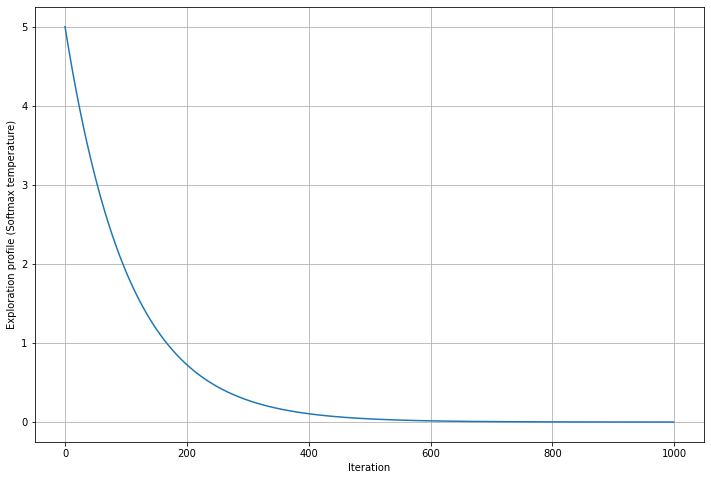

In [23]:
### Define exploration profile
initial_value = 5
num_iterations = 1000 #1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In the figure above we can see the exploration profile defined. In the cell below we can now call the function initializer_rm and the training function defined above to start the training.

In [24]:
replay_mem, policy_net, target_net, optimizer, loss = initializer_rm(param_dict)
scores = training(policy_net, target_net, replay_mem, exploration_profile, optimizer, loss, param_dict)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


EPISODE: 44 - FINAL SCORE: 35 - Temperature: 3.300925656226998
EPISODE: 45 - FINAL SCORE: 18 - Temperature: 3.2692032590398465
EPISODE: 46 - FINAL SCORE: 23 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 20 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 16 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 26 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 14 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 52 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 17 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 37 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 14 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SCORE: 18 - Temperature: 2.9682721884690775
EPISODE: 56 - FINAL SCORE: 43 - Temperature: 2.939746641659333
EPISODE: 57 - FINAL SCORE: 20 - Temperature: 2.911495229689364
EPISODE: 58 - FINAL SCORE: 17 - Temperature: 2.8835153180817
EPISODE: 59 - FINAL SCOR

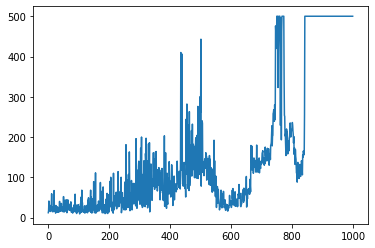

In [25]:
plt.plot(scores)

The highest score, 500, is reached with a stable trend after $\sim$ 850 episodes. The goal of the next sections will be to improve this trend and see if we are able to reach the highest score with fewer iterations.

The video related to this part can be found at this [link](https://github.com/giorgettisabrina/NNDL/tree/main/homework3/gif) . One can see that in the end (cartpole-learning-video) the cart has learned how to balance the pole.


In [26]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.1.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000100.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000200.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000300.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000400.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000500.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000600.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000700.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000800.mp4



SHOWING VIDEO video/openaigym.video.1.60.video000900.mp4


## Final test basic CartPole

In [27]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [28]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.2.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000009.mp4


The final test shows that the highest score is reached in all episodes.

# Optimization with hyperameters tuning

## Optuna study

[Optuna](https://optuna.readthedocs.io/en/stable/#) is a software framework for automating the optimization process of the hyperparameters of a neural network. It allows us to choose from different sampler algorithms, in our case, we'll make use of the *Random Search* sampler. An Optuna study has two main blocks:

- Objective function in which one specifies the hyperparameters to be considered, defines (or calls) the training loop and returns as output the object of the study.

- The Study creation (optuna.create_study) that defines the optimization session: one passes the objective function, and specifies the number of trials and the direction of the study, which can be either to "minimize" or to "maximize" the study object.


A trial corresponds to a single execution of the objective function to which a specific set of hyperparameters is associated; during the optimization, Optuna repeatedly calls and evaluates the objective function, and in the end the function study.best_trial returns the best set of values found. 

The parameters considered in this study are the following: 

|Parameter | Type of search | Range |
| --- | --- | --- | 
| gamma | float | [0.94, 0.98] | 
| Learning rate (lr) | loguniform | [1e-3,5e-1] |
|target_net_update_steps | categorical | 5,10 |
| batch_size | categorical | 128,256|


The objective of the study is the mean of the scores for that training and so the direction is the "maximize" one. 
As regards the type of search: *categorical* suggests a value from the list for the categorical parameter, *loguniform* will sample a floating value in the log domain for the continuous parameter while in the *float* case it will sample a number from that range. 

In [ ]:
!pip install optuna

In [30]:
import optuna

In [31]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [32]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

In [33]:
def objective(trial):

  param_dict = {             
  'gamma' : trial.suggest_float('gamma', 0.94, 0.98), #0.97,   # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : trial.suggest_loguniform('lr',1e-3, 5e-1),  # Optimizer learning rate
  'target_net_update_steps' : trial.suggest_categorical('target_net_update_steps', [5,10]), #10,   # Number of episodes to wait before updating the target network
  'batch_size' :  trial.suggest_categorical('batch_size', [128,256]),  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 1000,  # Minimum samples in the replay memory to enable the training
  }

  replay_mem, policy_net, target_net, optimizer, loss = initializer_rm(param_dict)
  scores = training(policy_net, target_net, replay_mem, exploration_profile, optimizer, loss, param_dict)

  return np.mean(scores) #Minimize idx = trial che raggiunge prima il score



In [34]:
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="maximize")
study.optimize(objective, n_trials=8, timeout=None, show_progress_bar=False)


[I 2022-07-03 13:56:03,776] A new study created in memory with name: myfirstoptimizationstudy


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559

[I 2022-07-03 14:30:51,851] Trial 0 finished with value: 310.404 and parameters: {'gamma': 0.964097305570249, 'lr': 0.02164134375588995, 'target_net_update_steps': 5, 'batch_size': 256}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 500 - Temperature: 0.00032310508900658505


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 13 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 24 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 20 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 24 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 21 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 12 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 16 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 47 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 15 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 29 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 18 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 13 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 18 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 15 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

[I 2022-07-03 14:40:01,669] Trial 1 finished with value: 109.744 and parameters: {'gamma': 0.9474214436947443, 'lr': 0.035057859922493335, 'target_net_update_steps': 10, 'batch_size': 128}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 292 - Temperature: 0.00032310508900658505


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 11 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 25 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 46 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 16 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 16 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: 18 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 25 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 16 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 26 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 38 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 15 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 26 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 22 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 43 - Temperature: 4.367737444559

[I 2022-07-03 14:47:23,128] Trial 2 finished with value: 64.582 and parameters: {'gamma': 0.9625567673276473, 'lr': 0.0014677509193182562, 'target_net_update_steps': 5, 'batch_size': 256}. Best is trial 0 with value: 310.404.


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 19 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 34 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 79 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 22 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 13 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 30 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 22 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 19 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 21 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 9 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 15 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 13 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCOR

[I 2022-07-03 15:03:52,844] Trial 3 finished with value: 200.501 and parameters: {'gamma': 0.9686933584625177, 'lr': 0.046412095623234215, 'target_net_update_steps': 10, 'batch_size': 128}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 500 - Temperature: 0.00032310508900658505


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 29 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 20 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 11 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 17 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 18 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 20 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 13 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 15 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 32 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 12 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 12 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 27 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 10 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 12 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 10 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

[I 2022-07-03 15:26:19,497] Trial 4 finished with value: 204.473 and parameters: {'gamma': 0.9776972444691687, 'lr': 0.3675089497249798, 'target_net_update_steps': 10, 'batch_size': 256}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 323 - Temperature: 0.00032310508900658505


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 61 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 23 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 14 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 20 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: 29 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 28 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 16 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 21 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 22 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 17 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 17 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 23 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 16 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 27 - Temperature: 4.367737444559

[I 2022-07-03 15:38:52,189] Trial 5 finished with value: 112.567 and parameters: {'gamma': 0.9619006381503229, 'lr': 0.0019763437504868816, 'target_net_update_steps': 5, 'batch_size': 256}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 402 - Temperature: 0.00032310508900658505


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 23 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 23 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 28 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 12 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 18 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 26 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 19 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 15 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 24 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 27 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 36 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 44 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 11 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 16 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

[I 2022-07-03 15:58:00,344] Trial 6 finished with value: 173.145 and parameters: {'gamma': 0.9502671641422401, 'lr': 0.029964830431954737, 'target_net_update_steps': 10, 'batch_size': 256}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 500 - Temperature: 0.00032310508900658505


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 34 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 14 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 15 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 9 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 15 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 47 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 35 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 83 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 34 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 62 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 18 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 22 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 82 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 11 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 11 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCOR

[I 2022-07-03 16:24:20,937] Trial 7 finished with value: 247.158 and parameters: {'gamma': 0.9575222426178521, 'lr': 0.1824007956053648, 'target_net_update_steps': 10, 'batch_size': 256}. Best is trial 0 with value: 310.404.


EPISODE: 1000 - FINAL SCORE: 500 - Temperature: 0.00032310508900658505


In [50]:
#save_study = optuna.create_study(study_name="studysave", direction="maximize", storage="sqlite:///cartpole8t.db")
#save_study.add_trials(study.trials)

[I 2022-07-03 16:34:26,379] A new study created in RDB with name: studysave
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: add_trials is experimental (supported from v2.5.0). The interface can change in the future.
  
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:969: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(trial)


In [35]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 8
Best trial:
  Value: 310.404
  Params: 
    gamma: 0.964097305570249
    lr: 0.02164134375588995
    target_net_update_steps: 5
    batch_size: 256


In [52]:
df_study = study_load.trials_dataframe(attrs={'number','value', 'duration', 'params', 'state'})
df_study

,number,params_batch_size,params_gamma,params_lr,params_target_net_update_steps,value,duration,state
0,0,256,0.964097,0.021641,5,310.404,0 days 00:34:48.069674,COMPLETE
1,1,128,0.947421,0.035058,10,109.744,0 days 00:09:09.815537,COMPLETE
2,2,256,0.962557,0.001468,5,64.582,0 days 00:07:21.453436,COMPLETE
3,3,128,0.968693,0.046412,10,200.501,0 days 00:16:29.712789,COMPLETE
4,4,256,0.977697,0.367509,10,204.473,0 days 00:22:26.650570,COMPLETE
5,5,256,0.961901,0.001976,5,112.567,0 days 00:12:32.688902,COMPLETE
6,6,256,0.950267,0.029965,10,173.145,0 days 00:19:08.150239,COMPLETE
7,7,256,0.957522,0.182401,10,247.158,0 days 00:26:20.589955,COMPLETE


In [48]:
print("Number of finished trials: {}".format(len(study_load.trials)))

print("Best trial:")
best_trial = study_load.best_trial

print("  Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 8
Best trial:
  Value: 64.582
  Params: 
    batch_size: 256
    gamma: 0.9625567673276473
    lr: 0.0014677509193182562
    target_net_update_steps: 5


# Optimized CartPole-v1

We now train the CartPole with the parameters found in the Optuna study: 
    
    
|Parameter |Value|
| --- | --- | 
| gamma | 0.96 | 
| Learning rate (lr) | 0.00147 |
|target_net_update_steps |5|
| batch_size | 256|

In [22]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


In [23]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

Problem in uploading the Optuna study in Colab so we'll manually define inside the dictionary of the parameters their values.

In [24]:
param_dict = {             
  'gamma' :  0.964097305570249,  # gamma parameter for the long term reward
  'replay_memory_capacity' : 10000,   # Replay memory capacity
  'lr' : 0.02164134375588995,  # Optimizer learning rate
  'target_net_update_steps' : 5,    # Number of episodes to wait before updating the target network
  'batch_size' : 256,  # Number of samples to take from the replay memory for each update
  'bad_state_penalty' : 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  'min_samples_for_training' : 1000,  # Minimum samples in the replay memory to enable the training
  }

In [25]:
replay_mem, policy_net, target_net, optimizer, loss = initializer_rm(param_dict)
best_scores = training(policy_net, target_net, replay_mem, exploration_profile, optimizer, loss, param_dict)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
Updating target network...
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


EPISODE: 44 - FINAL SCORE: 35 - Temperature: 3.300925656226998
EPISODE: 45 - FINAL SCORE: 18 - Temperature: 3.2692032590398465
Updating target network...
EPISODE: 46 - FINAL SCORE: 23 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 20 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 16 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 26 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 14 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 52 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 19 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 19 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 18 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SCORE: 18 - Temperature: 2.9682721884690775
Updating target network...
EPISODE: 56 - FINAL SCORE: 17 - Temperature: 2.939746641659333
EPISODE: 57 - FINAL SCORE: 20 - Temperature: 2.911495229689364
EPISODE: 58 - FINAL SCORE: 8 - 

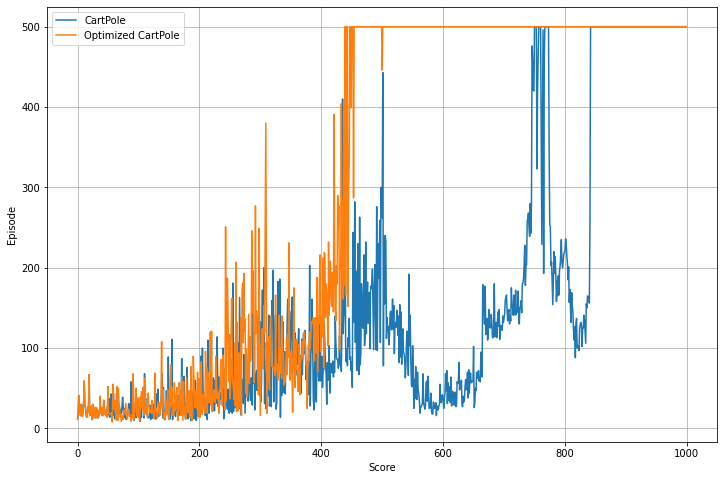

In [68]:
# Plot losses
plt.figure(figsize=(12,8))
#plt.semilogy
plt.plot(scores, label='CartPole')
plt.plot(best_scores, label='Optimized CartPole')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid()
plt.legend()
plt.show()

#Error in the plot Score is along the y-axis and episode along the x-axis, 
#Not able to change the plot as it would require to re-run the all section.

(Error in the plot Score is along the y-axis and episode along the x-axis)


As we can see from the plot with the optimized CartPole we are able to reach the highest score with just 500 episodes with is a big improvement from the 850 of the first case. We can assert that the optimization has been therefore successful.

In the cell below we run the final test which shows again that the score 500 is reached. We can see from the video  (optimized_cart_pole_final_test_video) that the cart is able to maintain in a vertical position the pole.

In [28]:
show_videos()


SHOWING VIDEO video/openaigym.video.1.59.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000100.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000200.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000300.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000400.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000500.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000600.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000700.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000800.mp4



SHOWING VIDEO video/openaigym.video.1.59.video000900.mp4


In [29]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [30]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.59.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.59.video000009.mp4


# Gym Environment MountainCar-v0




The MountainCar is another enviroment of the OpenAI Gym that consists of a car placed at the bottom of a sinusoidal valley. The goal is to reach the flag placed on top of the right hill, the only possibile action are the accelerations that can be applied to the car in either the left or right direction, buiding momentum the car can reach the flag. The agent is penalised with a reward of -1 for each timestep and the episode ends after 200 moves or if is the position of the car is greater than or equal to 0.5, where the flag is.

The implementation and the theoretical references are analogous to one of the CartPole.

## Enable gym environment rendering in Colab


In [3]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu b

In [4]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [5]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [6]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Make MountainCar-v0 environment

In [8]:
#env = gym.make("MountainCarContinuous-v0")
env = gym.make("MountainCar-v0")

env.seed(0)

print(env.action_space)
print(env.observation_space)
# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

Discrete(3)
Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


## Reinforced learning functions definition

### DQN class, Repley Memory, action function

In [9]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [10]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [11]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state) #outputs are the q-values

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [12]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [13]:
# Define an example network
net = DQN(state_space_dim=2, action_space_dim=3) 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

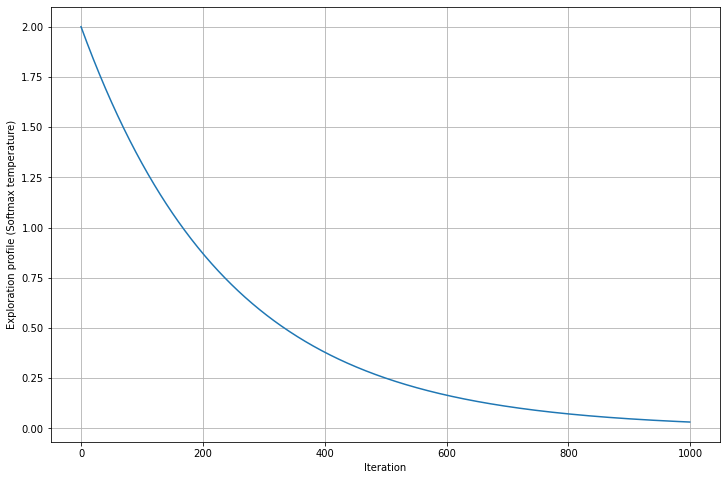

In [15]:
### Define exploration profile
initial_value = 2
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

### Network update

In [16]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 5e-2 # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [17]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [18]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Run 

In [19]:
# Initialize the Gym environment
env = gym.make("MountainCar-v0")
env.seed(0)

scores =[]

env = wrap_env(env, video_callable=lambda episode_id: episode_id % 200 == 0) 


for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Action space 
      #0- Accelerate to the left
      #2- Accelerate to the right
  
      #Define the reward 
      if next_state[0] - state[0] > 0 and action == 2: reward += 1
      if next_state[0] - state[0] < 0 and action == 0: reward += 1   
      if next_state[0] >=0.5 : reward += 1 

      # Update the final score 
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    scores.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -130.0 - Temperature: 2.0
EPISODE: 2 - FINAL SCORE: -127.0 - Temperature: 1.9916995061889162
EPISODE: 3 - FINAL SCORE: -128.0 - Temperature: 1.9834334614765863
EPISODE: 4 - FINAL SCORE: -124.0 - Temperature: 1.975201722890745
EPISODE: 5 - FINAL SCORE: -123.0 - Temperature: 1.9670041480524967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


EPISODE: 6 - FINAL SCORE: -116.0 - Temperature: 1.9588405951738537
EPISODE: 7 - FINAL SCORE: -114.0 - Temperature: 1.9507109230552835
EPISODE: 8 - FINAL SCORE: -111.0 - Temperature: 1.9426149910832666
EPISODE: 9 - FINAL SCORE: -115.0 - Temperature: 1.934552659227864
EPISODE: 10 - FINAL SCORE: -115.0 - Temperature: 1.9265237880402957
Updating target network...
EPISODE: 11 - FINAL SCORE: -127.0 - Temperature: 1.9185282386505287
EPISODE: 12 - FINAL SCORE: -129.0 - Temperature: 1.9105658727648747
EPISODE: 13 - FINAL SCORE: -122.0 - Temperature: 1.9026365526635982
EPISODE: 14 - FINAL SCORE: -123.0 - Temperature: 1.8947401411985352
EPISODE: 15 - FINAL SCORE: -114.0 - Temperature: 1.88687650179072
EPISODE: 16 - FINAL SCORE: -118.0 - Temperature: 1.8790454984280234
EPISODE: 17 - FINAL SCORE: -113.0 - Temperature: 1.8712469956628
EPISODE: 18 - FINAL SCORE: -120.0 - Temperature: 1.863480858609546
EPISODE: 19 - FINAL SCORE: -117.0 - Temperature: 1.8557469529425652
EPISODE: 20 - FINAL SCORE: -125.

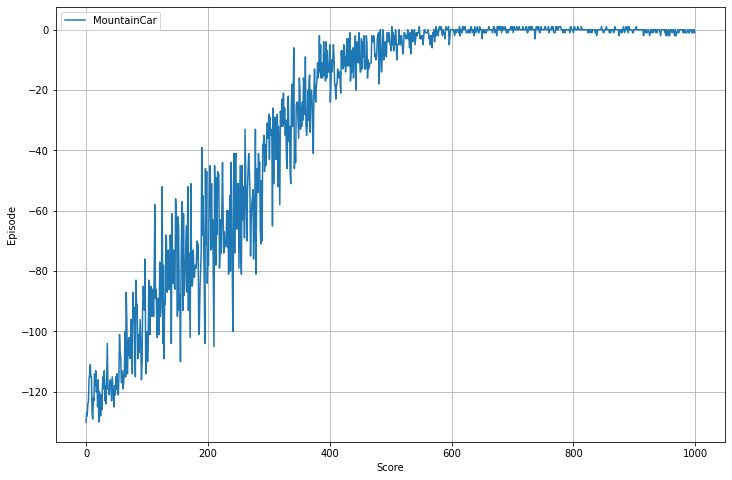

In [20]:
# Plot losses
plt.figure(figsize=(12,8))
plt.plot(scores, label='MountainCar')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid()
plt.legend()
plt.show()

#Error in the plot Score is along the y-axis and Episode along the x-axis, 
#Not able to change the plot as it would require to re-run the all section.

In [21]:
show_videos()



SHOWING VIDEO video/openaigym.video.0.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000200.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000400.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000600.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000800.mp4


In [19]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000200.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000400.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000600.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000800.mp4


## Final test 

In [31]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score - check if car reaches the flag
      if next_state[0] - state[0] > 0 and action == 2: reward += 1
      if next_state[0] - state[0] < 0 and action == 0: reward += 1   
      if next_state[0] >=0.5 : reward += 1 
      score = reward
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 1.0
EPISODE 2 - FINAL SCORE: 1.0
EPISODE 3 - FINAL SCORE: 1.0
EPISODE 4 - FINAL SCORE: 1.0
EPISODE 5 - FINAL SCORE: 1.0
EPISODE 6 - FINAL SCORE: 1.0
EPISODE 7 - FINAL SCORE: 1.0
EPISODE 8 - FINAL SCORE: 1.0
EPISODE 9 - FINAL SCORE: 1.0
EPISODE 10 - FINAL SCORE: 1.0


In [32]:
show_videos()


SHOWING VIDEO video/openaigym.video.8.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000001.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000002.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000003.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000004.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000005.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000006.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000007.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000008.mp4



SHOWING VIDEO video/openaigym.video.8.60.video000009.mp4


The video related to this part can be found at this [link]. 
In the videos mountaincar_learning_fail and mountaincar_learning one can see that at first, the car has not learned how to gain momentum to reach the top but after 600 episodes, moving back and forth, it touches the flags. In the mountaincar_fina_test video we have a confirmation of the learned behaviour, the car with just few moves reaches the flag.